In [256]:
import time
import torch as tr
from torch import nn
import torch.optim as opt
from torch.utils.data import DataLoader, Dataset
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import numpy as np
import typing
from typing import Callable, Tuple
import matplotlib as mt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [257]:
option                           =3
exp=[                            # Options: 
     "DiscreteSpectrumExample",  # 1)
     "FluidFlowBox",             # 2)
     "FluidFlowOnAttractor",     # 3)
     "Pendulum"                  # 4)
     ]

In [258]:
max_initial_conditions=None

In [259]:
device='cpu'

In [260]:
if option not in [3]:
    raise Exception("Option invalid, please stick with the option proposed...")
dataDir="data/"
match exp[option-1]:
    case "FluidFlowOnAttractor":
        max_tr       =3
        coor         =3
        dimEncoder   =[105,2]
        dimAuxNet    =[300]
        RE_IMG_eigAux=(0,1)
        impRadialSymm=True
        numShift     =30
        numLinShift  =120 
        lamb         =[0.1,0.1,1.0,1e-7]
        lamb_l2      =1e-13
        lr           =1e-3
        Dt           =0.05
        lenTrj       =121
        batchSize    =256
        seqEncoder=(
                    nn.Linear(coor          ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,dimEncoder[1])
                    )
        seqDecoder=(
                    nn.Linear(dimEncoder[1] ,dimEncoder[0]),nn.ReLU(),
                    nn.Linear(dimEncoder[0] ,coor         )
                    )
        tmpAuxInputDim=dimEncoder[-1] if not impRadialSymm else 1
        auxNet    =(
                    nn.Linear(tmpAuxInputDim,dimAuxNet[0]),nn.ReLU(),
                    nn.Linear(dimAuxNet[0]  ,1           )
                    )
    case EXP:
        raise Exception(f"Experiment Option not found.... [{EXP}]")




        
filesTrain=[dataDir+exp[option-1]+"_train"+str(i)+"_x.csv" for i in range(1,max_tr+1)]
fileVali=dataDir+exp[option-1]+"_val_x.csv"
fileTest=dataDir+exp[option-1]+"_test_x.csv"
print("Experiment",exp[option-1]+", files train:")
for f in filesTrain:
    print("\t\t"+f)
print("\nFile Validation:\t",fileVali)
print("File Test:\t\t",fileTest)

Experiment FluidFlowOnAttractor, files train:
		data/FluidFlowOnAttractor_train1_x.csv
		data/FluidFlowOnAttractor_train2_x.csv
		data/FluidFlowOnAttractor_train3_x.csv

File Validation:	 data/FluidFlowOnAttractor_val_x.csv
File Test:		 data/FluidFlowOnAttractor_test_x.csv


In [261]:
class customDataSet(Dataset):

    def __init__(self, filenames: str|list[str], coor: int, Nshift: int, NLshift: int, lenTraje: int, debug: bool = False) -> None:
        super().__init__()
        self._data=tr.Tensor([])
        self._Nshift =Nshift
        self._NLshift=NLshift
        self._maxNshift=max(Nshift,NLshift)
        self._coor=coor
        self._event4file=[]
        names=["x_"+str(i) for i in range(coor)]
        multiplefiles=False
        if isinstance(filenames,list):
            L=len(filenames)
            if L>1:
                multiplefiles=True
            else:
                filenames=filenames[0]
        if multiplefiles:
            self._dataPD=pd.concat([pd.read_csv(f,header=None,names=names) for f in filenames])
        else:
            self._dataPD=pd.read_csv(filenames,names=names) 
        
        if (lenTraje<=self._maxNshift):
            raise Exception(f"Trajectories in file is lenTraje={lenTraje} long, but you want to extract {self._maxNshift} time steps")
        IC=len(self._dataPD)//lenTraje
        for i in range(IC if max_initial_conditions==None or IC<max_initial_conditions else max_initial_conditions):
            tmp=[tr.tensor(self._dataPD[i*lenTraje+j:i*lenTraje+j+self._maxNshift+1].values).unsqueeze(0).float() for j in range(lenTraje-self._maxNshift)]
            self._data=tr.cat((self._data,*tmp)) # This will put as first dimension the  numebr of time-shift, the second-one is the batch size and third the number of coordinates

        if not debug:
            self._dataPD=None

    
    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self,i: int) -> tr.tensor:
        return self._data[i]

In [262]:
# We create the datasets for training, validate and test the model using the files listed above  ^ ^ ^
DATA_TR=customDataSet(filesTrain,coor,numShift,numLinShift,lenTrj)
DATA_VL=customDataSet(fileVali  ,coor,numShift,numLinShift,lenTrj)
DATA_TS=customDataSet(fileTest  ,coor,numShift,numLinShift,lenTrj)

In [263]:
# From the datasets we create DataLoaders that group our datasets in batches
train=DataLoader(DATA_TR,batch_size=batchSize,shuffle=True ,drop_last=True)
vali =DataLoader(DATA_TR,batch_size=batchSize,shuffle=True ,drop_last=True)
test =DataLoader(DATA_TR,batch_size=batchSize,shuffle=False,drop_last=True)

In [264]:
next(iter(train))[0:3,:5]

tensor([[[ 0.1505,  0.0614,  0.0264],
         [ 0.1479,  0.0691,  0.0265],
         [ 0.1450,  0.0768,  0.0266],
         [ 0.1417,  0.0844,  0.0268],
         [ 0.1379,  0.0918,  0.0270]],

        [[-0.1228,  0.4299,  0.1999],
         [-0.1447,  0.4249,  0.2002],
         [-0.1664,  0.4188,  0.2010],
         [-0.1879,  0.4116,  0.2022],
         [-0.2090,  0.4033,  0.2036]],

        [[-0.2224, -0.3089,  0.1449],
         [-0.2076, -0.3210,  0.1452],
         [-0.1921, -0.3324,  0.1458],
         [-0.1760, -0.3431,  0.1467],
         [-0.1593, -0.3529,  0.1478]]])

## Loss function
The loss function they decided to use (and obviously the architecture itself) enforces constraints specifically designed to extract the fewest meaningful eigenfunctions; it consists of three weighted mean-squared error components: a reconstruction loss $\mathcal{L}_{recon}$, included in order to obtain a good reconstruction accuracy of the auto-encoder, the loss future state prediction $\mathcal{L}_{pred}$, necessary to have intrinsic coordinates that allow future state prediction,  linearity of dynamics loss $\mathcal{L}_{lin}$, which enforces linear prediction over m time steps. They also use a $\mathcal{L}_{\infty}$
 term to penalty the data point with the largest loss. They also add $ℓ_2$
 regularization on the weights W to reduce overfitting. We decided to not do that because and we simply thought to make the weights smaller by adding a weight decay to Adam. However, as pointed out in [this paper](https://openreview.net/pdf?id=rk6qdGgCZ), the two things do not coincide, but we still found it effective in reducing overfitting. Their loss is:
 $$ \mathcal{L} = \alpha_1 (\mathcal{L}_{recon} + \mathcal{L}_{pred}) + \mathcal{L}_{lin} + \alpha_2 \mathcal{L}_{\infty} + \alpha_3 ||\textbf{W}||^2_2$$
 
 $$ \mathcal{L}_{recon} = ||\textbf{x}_1 - \varphi^{-1}(\varphi(\textbf{x}_1))||_{\text{MSE}}$$
 $$ \mathcal{L}_{pred} = \frac{1}{S_p} \sum_{m=1}^{S_p} ||\textbf{x}_{m+1} -  \varphi^{-1}(K^m \varphi(\textbf{x}_1))||_{\text{MSE}}$$
 $$ \mathcal{L}_{lin} = \frac{1}{T - 1} \sum_{m=1}^{T-1} ||\varphi(\textbf{x}_{m+1}) - K^m \varphi(\textbf{x}_1)||_{\text{MSE}}$$
  $$ \mathcal{L}_{\infty} = ||\textbf{x}_1 - \varphi^{-1}(\varphi(\textbf{x}_1))||_{\infty} + ||\textbf{x}_2 - \varphi^{-1}(K\varphi(\textbf{x}_1))||_{\infty}$$
  where $\text{MSE}$ refers to mean squared error and T is the number of time steps in each trajectory. The weights $\alpha_1$, $\alpha_2$, and $\alpha_3$ are hyperparameters which are different for each example. The integer $S_p$ is a hyperparameter for how many steps to check in the prediction loss. In our case we do not have the term proportional to $|| W ||_2^2|| $ and the weight decay was set equal to $\alpha_3$.


In [306]:
class CustomLoss(nn.Module):
    def __init__(self,Nshift: int, NLshift: int) -> None:
        super().__init__()
        #self._Nshift =Nshift
        #self._NLshift=NLshift
        self.loss_reco=nn.MSELoss()
        #self.loss_pred=nn.MSELoss()
        #self.loss_line=nn.MSELoss()
        #self.loss_linf: Callable[[tr.tensor,tr.tensor,tr.tensor,tr.tensor],tr.tensor]=\
        #    lambda x,y,x1,y1: ((x-y).abs().max(dim=-1)[0]+(x1-y1).abs().max(dim=-1)[0]).mean()

    #XT contains the true time-evolved starting from the initials points of trajectories in a batch, YT the predicted ones.
    def forward(self, XT: tr.tensor, YT: tr.tensor, phiT: tr.tensor, phiPredT: tr.tensor) -> tr.tensor:

        totLoss=        self.loss_reco(XT[0],YT[0]) * lamb[0]
        # totLoss=totLoss+self.loss_pred(XT[1:self._Nshift+1],YT[1:self._Nshift+1])           * lamb[1]
        # totLoss=totLoss+self.loss_line(phiT[1:self._NLshift+1],phiPredT[1:self._NLshift+1]) * lamb[2]
        # totLoss=totLoss+self.loss_linf(XT[0],YT[0],XT[1],YT[1])                             * lamb[3]

        return  totLoss

      

In [307]:
#metric   = MeanSquaredError()
metric   = MeanAbsoluteError() # As metric we used the MAE between a point evolved one time step in the future and the correspondent prediction done by the Net
loss     = CustomLoss(numShift,numLinShift)

In [308]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers=nn.Sequential(*seqEncoder)
    def forward(self,x: tr.tensor) -> tr.tensor:
        return self.layers(x)

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers=nn.Sequential(*seqDecoder)
    def forward(self,x: tr.tensor) -> tr.tensor:
        return self.layers(x)


#==================================================================================================
#--------------------------------------------------------------------------------------------------
#==================================================================================================

class K_Matrix(nn.Module):
    '''
    `K_Matrix` is the realization of the whole process of fixing the continous parameters and applying the matrix. It is responsible of the evolution
    in time. It acts on the Koopman subspace.
    If it is initialized with `radialS,radialSymmetry: bool =Falseymmetry` setted to True, the matrix eigenvalues will be calculated from vector lenght information (not direction)
    '''
    def __init__(self) -> None:
        super().__init__()
        self.auxNet=nn.Sequential(nn.Linear(2,300),nn.ReLU(),
                                  nn.Linear(300,2)          )
        self.M=None
    def forward(self,x,shift):
        # We compose the Jordan matrix fixing the real parameters
        PR=self.auxNet(x).T
        R=tr.exp(PR[0]*Dt)
        C=tr.cos(PR[1]*Dt)
        S=tr.sin(PR[1]*Dt)
        M=tr.cat([R*C,R*S,
                 -R*S,R*C]).reshape(2,2,-1).permute(2,0,1)
        self.M=M.clone()
        # We evolve in time applying the matrix product between the point in Koopman subspace and the Jordan matrix
        M=tr.linalg.matrix_power(M,shift)
        x=x.unsqueeze(-1)
        res=M.bmm(x).squeeze(-1) # N.B. the matrix is shaped (`batchSize`,`n`,`n`) with `n` the dimension of the Koopman subspace.
                                               #      to perform batch matrix multplication we had to tranform the vector in a `n`x 1 matrix 
                                               #      (`batchSize`,`n`,1). Than we had to squeeze back the result in vectorial form (`batchSize`,`n`)
        return res



In [309]:
Nt=max(numShift,numLinShift)
print(f"Numero di predizioni che il modello compie: {Nt}")

Numero di predizioni che il modello compie: 120


In [319]:
class KOOPMAN(nn.Module):
    def __init__(self, pred: int ,radialSymmetry: bool =False) -> None:
        super().__init__()
        self.ENC=Encoder()
        self.K=K_Matrix()
        self.Npred=pred
        self.DEC=Decoder()
    def forward(self,XT: tr.tensor,NShift: int) -> Tuple[tr.tensor,tr.tensor,tr.tensor,tr.tensor]:
        PhiT=self.ENC(XT.reshape(-1,coor))
        arr=[]
        for i in range(self.Npred+1):
            arr.append(self.K(PhiT,i))
        PhiPredT=tr.cat(arr)
        YT=self.DEC(PhiPredT).reshape(self.Npred+1,len(XT),batchSize,coor)
        return XT, YT, PhiT.reshape(len(XT),batchSize,dimEncoder[-1]),PhiPredT.reshape(self.Npred+1,len(XT),batchSize,dimEncoder[-1])


In [320]:
model=KOOPMAN(5)
print(model)

KOOPMAN(
  (ENC): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=105, bias=True)
      (1): ReLU()
      (2): Linear(in_features=105, out_features=2, bias=True)
    )
  )
  (K): K_Matrix(
    (auxNet): Sequential(
      (0): Linear(in_features=2, out_features=300, bias=True)
      (1): ReLU()
      (2): Linear(in_features=300, out_features=2, bias=True)
    )
  )
  (DEC): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=105, bias=True)
      (1): ReLU()
      (2): Linear(in_features=105, out_features=3, bias=True)
    )
  )
)


## Training Procedure

They initialized each weight matrix W randomly from a uniform distribution in the range $[-s, s]$ for $s = \frac{1}{\sqrt{a}}$, where $a$ is the dimension of the input of the layer. Each bias vector $b$ is initialized to 0. The learning rate for the Adam optimizer is 0.001. We also use early stopping; for each model, at the end of training, we resume the step with the lowest validation error.

In [321]:
EPOCHS=100  # Number of epochs for the training
patience=20 # If after `patience` epochs the model did not improve, the training is automatically stopped
lr=0.01
lamb_l2=0
optim= opt.Adam(params=model.parameters(),lr=lr,weight_decay=lamb_l2)

In [322]:
class LossRECO(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.loss_reco=nn.MSELoss()
        

    def forward(self, XT: tr.tensor, YT: tr.tensor) -> tr.tensor:

        totLoss=        self.loss_reco(XT,YT[0])
        return  totLoss


In [344]:
class LossPRED(nn.Module):
    def __init__(self,Nshift) -> None:
        super().__init__()
        self.loss_pred=nn.MSELoss()
        self.loss_array=nn.MSELoss(reduction='none')
        self.NT=Nshift

    def forward(self, XT: tr.tensor, YT: tr.tensor) -> tr.tensor:
        totLoss=        self.loss_pred(XT[1:self.NT+1],YT[1:self.NT+1,0])
        return  totLoss, self.loss_array(XT[1:self.NT+1],YT[1:self.NT+1,0]).mean(dim=(-2,-1))

class LossPRED_PHI(nn.Module):
    def __init__(self,Nshift) -> None:
        super().__init__()
        self.loss_pred=nn.MSELoss()
        self.loss_array=nn.MSELoss(reduction='none')
        self.NT=Nshift

    def forward(self, phiT: tr.tensor, phiPredT: tr.tensor) -> tr.tensor:

        totLoss=        self.loss_pred(phiT[1:self.NT+1],phiPredT[1:self.NT+1,0])
        return  totLoss, self.loss_array(phiT[1:self.NT+1],phiPredT[1:self.NT+1,0]).mean(dim=(-2,-1))


In [324]:
class EarlyStopping(Exception):
    '''
    Custom exception to raise in case of stop due to number of epochs in which the model did not improve greater than `patience`.
    '''
    def __init__(self) -> None:
        super().__init__()
    


class SaveBestModel:
    '''
    This utility is needed to save the best model (choosen using the one that minimizes the loss on the validation dataset) and to check if
    any improvement as occurred during last epochs.
    `best_valid_loss` is the minimum of the loss found
    `best_epoch`      is the epoch at witch the validation was minimal
    `patience`        is the maximum number of epochs that we consider the model to have the potential of improving over the last updating
    '''
    def __init__(self,patience=100, best_vali_loss=float('inf')) -> None: #object initialized with best_loss = +∞
        self.best_vali_loss = best_vali_loss
        self.patience=patience
        self.best_epoch=0
        self._fromLastUpdate=0
        
    def __call__(
        self, current_vali_loss: float, epoch: int,
        model: nn.Module, 
        optimizer: opt.Optimizer,
        criterion: Callable[[tr.tensor,tr.tensor],float], 
        metric: float
    ):
        if current_vali_loss < self.best_vali_loss:
            # Private attribute containing the last epochs in which the model improved
            self._fromLastUpdate=0
            self.best_vali_loss = current_vali_loss
            print(f"\nBest validation loss: {self.best_vali_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            tr.save({
                     'epoch': epoch+1,
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'loss': criterion,
                     'metric': metric
                    },
                    'best_model.pth')
            self.best_epoch=epoch+1
        else:
            self._fromLastUpdate+=1

        # Trow an exception if model has to stop due to early stopping
        if self._fromLastUpdate>self.patience:
            raise EarlyStopping

In [325]:
save_best_model=SaveBestModel(patience)

In [326]:
EPOCHS=10
loss0=LossRECO()

In [327]:
save_best_model=SaveBestModel(patience)
# Lists containing history during epochs of:
h_loss_tr  =[] # loss on train dataset
h_metric_tr=[] # metric on train dataset
h_loss_vl  =[] # loss on validation dataset
h_metric_vl=[] # metric on validation dataset

metric.to(device)
model=model.to(device)
for e in range(EPOCHS):
    t0=time.time()
    # Put model in train mode
    model.train()
    lossVal=0.0
    metrVal=0.0
    nbatch=0
    # Loop for each batch in all the train dataset
    for x in train:
        XT=x.to(device).swapaxes(0,1)
        nbatch+=1
        XT, YT, PhiT,PhiPredT=model(XT,Nt)
        l=loss0(XT, YT)
        m=0.#metric(XT[1],YT[1])
        l.backward()
        optim.step()
        optim.zero_grad()
        lossVal+=l.item()
        metrVal+=0.#m.item()
        
    # Normalize the loss and the metric to have the mean value between all the batches
    lossVal/=nbatch
    metrVal/=nbatch
    h_loss_tr.append(lossVal)
    h_metric_tr.append(metrVal)

    # Put model in evaluation mode
    model.eval()
    vl_lossVal=0.0
    vl_metrVal=0.0
    nbatch=0
    # Loop for each batch in all the validation dataset
    for x in vali:
        nbatch+=1
        XT=x.to(device).swapaxes(0,1)
        XT, YT, PhiT,PhiPredT=model(XT,Nt)
        l=loss0(XT, YT)
        m=0.#metric(XT[1],YT[1])
        vl_lossVal+=l.item()
        vl_metrVal+=0.#m.item()
    vl_lossVal/=nbatch
    vl_metrVal/=nbatch
    h_loss_vl.append(vl_lossVal)
    h_metric_vl.append(vl_metrVal)

    elapsed_time = time.time()-t0    
    print(f"epoch: {e+1}, time(s): {elapsed_time:.2f}, train loss: {lossVal:.6f}, train metric: {metrVal:.6f}, vali loss: {vl_lossVal:.6f}, vali metric: {vl_metrVal:.6f}")
    try: 
        save_best_model(vl_lossVal,e,model,optim,metric,metrVal)
    except EarlyStopping:
        print(f"Early Stopping occurred at epoch: {e+1}, best validation loss is {save_best_model.best_vali_loss}")
        break
    



epoch: 1, time(s): 39.40, train loss: 0.007308, train metric: 0.000000, vali loss: 0.000234, vali metric: 0.000000

Best validation loss: 0.00023355407204784067

Saving best model for epoch: 1

epoch: 2, time(s): 37.81, train loss: 0.000060, train metric: 0.000000, vali loss: 0.000032, vali metric: 0.000000

Best validation loss: 3.1809031560410874e-05

Saving best model for epoch: 2



KeyboardInterrupt: 

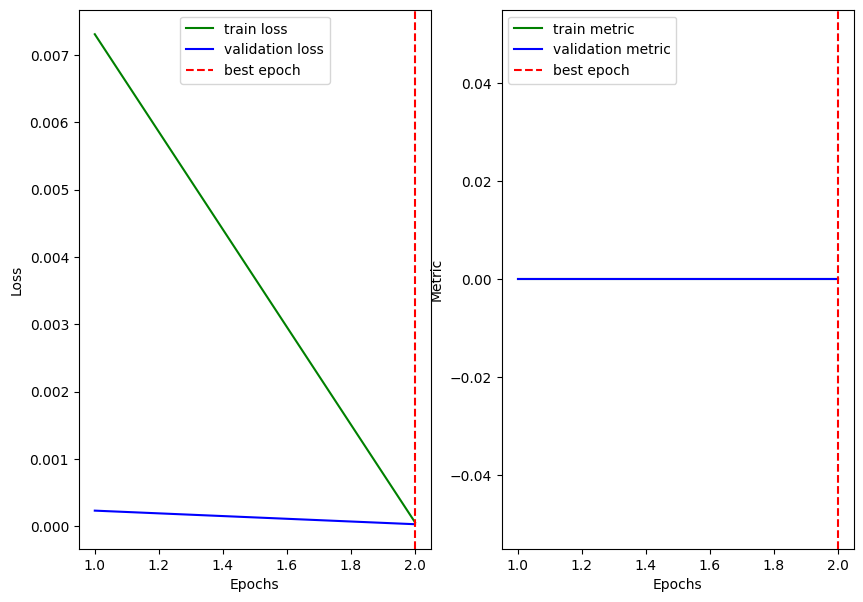

In [328]:
best_epoch=save_best_model.best_epoch
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(h_loss_tr)+1),   h_loss_tr, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(h_loss_vl)+1),  h_loss_vl, color='blue', linestyle='-', label='validation loss')
plt.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(h_metric_tr)+1),  h_metric_tr,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(h_metric_vl)+1),  h_metric_vl, color='blue', linestyle='-', label='validation metric')
plt.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [345]:
EPOCHS=20
T=5
loss1=LossPRED(T)
loss2=LossPRED_PHI(T)

In [346]:
lr=0.0002
lamb_l2=0
optim= opt.Adam(params=model.parameters(),lr=lr,weight_decay=lamb_l2)

In [350]:
save_best_model=SaveBestModel(patience)
# Lists containing history during epochs of:
h_loss_tr  =[] # loss on train dataset
h_metric_tr=[] # metric on train dataset
h_loss_vl  =[] # loss on validation dataset
h_metric_vl=[] # metric on validation dataset

H_LOSS_VL=[]


metric.to(device)
model=model.to(device)
maxShift=max(numShift,numLinShift) # The model will provide prediction to fulfill the bigger requirement in term of 
                                   # time-shift in the future, then the custom loss use only the needed time-spans
for e in range(EPOCHS):
    t0=time.time()
    # Put model in train mode
    model.train()
    lossVal=0.0
    metrVal=0.0
    nbatch=0
    # Loop for each batch in all the train dataset
    for x in train:
        XT=x.to(device).swapaxes(0,1)
        nbatch+=1
        XT, YT, PhiT,PhiPredT=model(XT,Nt)
        l1,lA1=loss1(XT, YT)
        l2,lA2=loss2(PhiT,PhiPredT)
        lA=lA1+lA2
       
        l=l1+l2#+loss0(XT,YT)
        m=0.#metric(XT[1],YT[1])
        l.backward()
        optim.step()
        optim.zero_grad()
        lossVal+=l.item()
        metrVal+=0.#m.item()
        
    # Normalize the loss and the metric to have the mean value between all the batches
    lossVal/=nbatch
    metrVal/=nbatch

    h_loss_tr.append(lossVal)
    h_metric_tr.append(metrVal)

    # Put model in evaluation mode
    model.eval()
    vl_lossVal=0.0
    vl_metrVal=0.0
    nbatch=0
    # Loop for each batch in all the validation dataset
    lA=0.
    for x in vali:
        nbatch+=1
        x=x.to(device).swapaxes(0,1)
        XT, YT, PhiT,PhiPredT=model(x,Nt)
        l1,lA1=loss1(XT, YT)
        l2,lA2=loss2(PhiT,PhiPredT)
        lA=lA+lA1+lA2
        l=l1+l2*0.#+loss0(XT,YT)
        #m=metric(XT[1],YT[1])
        vl_lossVal+=l.item()
        vl_metrVal+=0.#m.item()
    vl_lossVal/=nbatch
    vl_metrVal/=nbatch
    H_LOSS_VL.append(lA.detach().numpy()/nbatch)
    h_loss_vl.append(vl_lossVal)
    h_metric_vl.append(vl_metrVal)

    elapsed_time = time.time()-t0    
    print(f"epoch: {e+1}, time(s): {elapsed_time:.2f}, train loss: {lossVal:.6f}, train metric: {metrVal:.6f}, vali loss: {vl_lossVal:.6f}, vali metric: {vl_metrVal:.6f}")
    try: 
        save_best_model(vl_lossVal,e,model,optim,metric,metrVal)
    except EarlyStopping:
        print(f"Early Stopping occurred at epoch: {e+1}, best validation loss is {save_best_model.best_vali_loss}")
        break




epoch: 1, time(s): 39.73, train loss: 0.000782, train metric: 0.000000, vali loss: 0.000099, vali metric: 0.000000

Best validation loss: 9.943240089843788e-05

Saving best model for epoch: 1

epoch: 2, time(s): 32.69, train loss: 0.000435, train metric: 0.000000, vali loss: 0.000074, vali metric: 0.000000

Best validation loss: 7.388031622997068e-05

Saving best model for epoch: 2

epoch: 3, time(s): 33.44, train loss: 0.000312, train metric: 0.000000, vali loss: 0.000062, vali metric: 0.000000

Best validation loss: 6.182082933233248e-05

Saving best model for epoch: 3

epoch: 4, time(s): 38.17, train loss: 0.000246, train metric: 0.000000, vali loss: 0.000054, vali metric: 0.000000

Best validation loss: 5.3873715120877524e-05

Saving best model for epoch: 4

epoch: 5, time(s): 39.01, train loss: 0.000196, train metric: 0.000000, vali loss: 0.000048, vali metric: 0.000000

Best validation loss: 4.8119542168870825e-05

Saving best model for epoch: 5

epoch: 6, time(s): 35.27, train l

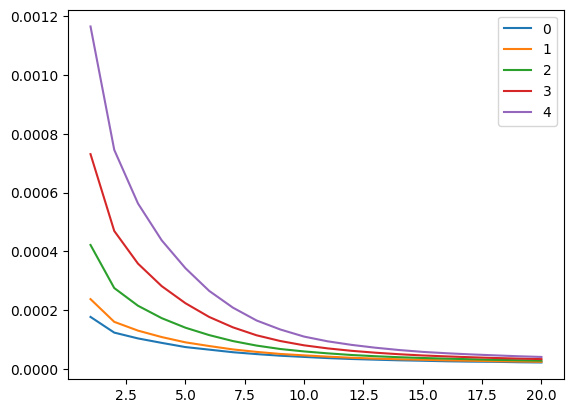

In [351]:
H_LOSS_VL_PLOT=np.stack(H_LOSS_VL).T
for i,h in enumerate(H_LOSS_VL_PLOT):
    plt.plot(list(range(1,len(h)+1)),h,label=str(i))

plt.legend()

In [352]:
model.K(model.ENC(XT[0]),1)
print(model.K.M[3])

tensor([[ 1.0003, -0.0568],
        [ 0.0568,  1.0003]], grad_fn=<SelectBackward0>)


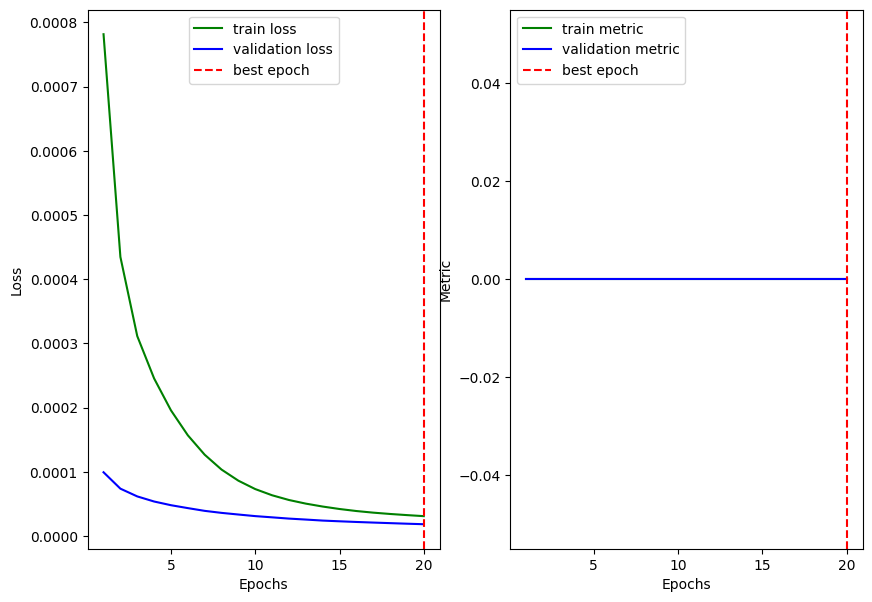

In [353]:
best_epoch=save_best_model.best_epoch
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(h_loss_tr)+1),   h_loss_tr, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(h_loss_vl)+1),  h_loss_vl, color='blue', linestyle='-', label='validation loss')
plt.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(h_metric_tr)+1),  h_metric_tr,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(h_metric_vl)+1),  h_metric_vl, color='blue', linestyle='-', label='validation metric')
plt.axvline(best_epoch,color="r",linestyle="--",label="best epoch")
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

## TEST results

In [356]:
model.cpu()
metric.cpu()
# Put model in evaluation mode
model.eval()
ts_lossVal=0.0
ts_metrVal=0.0
nbatch=0
maxShift=max(numShift,numLinShift)
# Loop for each batch in all the test dataset
for x in test:
    nbatch+=1
    x=x.cpu().swapaxes(0,1)
    XT, YT, PhiT,PhiPredT=model(x,0)
    #l=loss(XT, YT, PhiT,PhiPredT)
    m=0.#metric(XT[1],YT[1])
    ts_lossVal+=0#l.item()
    ts_metrVal+=0.#m.item()
ts_lossVal/=nbatch
ts_metrVal/=nbatch
print(f"Loss value on TEST dataset:\t{ts_lossVal}\nMetric on TEST dataset:\t\t{ts_metrVal}")

Loss value on TEST dataset:	0.0
Metric on TEST dataset:		0.0


## Graphs

In order to test our model we considered the following plots:

1) The correlation $ \langle \textbf{x}(k) , \textbf{x}(k+ m) \rangle $ at different discrete time steps m (evolution provided by the network) and fixed k and we compared it with the result found with numerical integration.
2) $\textbf{x}_i (k)\ \text{vs}\ \textbf{x}_j (k)$ at different time steps k (evolution provided by the network).

/tmp/ipykernel_2485/3402665208.py:36: UserWarning: Glyph 9 (	) missing from current font.
  fig.savefig("correlations.png")
/home/giuly/Documenti/code/KOOPMAN_AML2023/.venv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/home/giuly/Documenti/code/KOOPMAN_AML2023/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


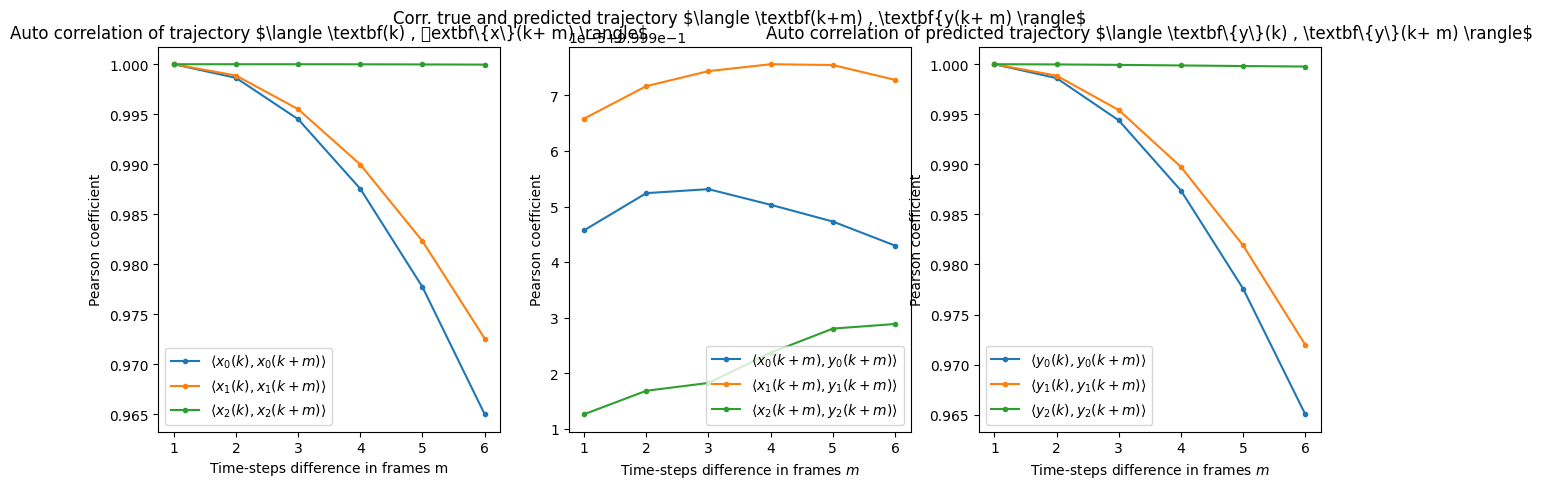

In [359]:
X_corr_m=XT[:T+1].permute((2,0,1)).cpu().detach().numpy()
Y_corr_m=YT[:T+1,0,:].permute((2,0,1)).cpu().detach().numpy()

#plt.rcParams['text.usetex'] = True
plt.rcParams['text.usetex']=False
fig,axs=plt.subplots(1,3,figsize=(15,5))
ax1,ax2,ax3=axs
ax1.set_title("Auto correlation of trajectory \$\\langle \\textbf(k) , \textbf\{x\}(k+ m) \\rangle$")
ax1.set_xlabel("Time-steps difference in frames m")
ax1.set_ylabel("Pearson coefficient")
ax2.set_title("Corr. true and predicted trajectory \$\\langle \\textbf(k+m) , \\textbf{y(k+ m) \\rangle$")
ax2.set_xlabel("Time-steps difference in frames $m$")
ax2.set_ylabel("Pearson coefficient")
ax3.set_title("Auto correlation of predicted trajectory \$\\langle \\textbf\{y\}(k) , \\textbf\{y\}(k+ m) \\rangle$")
ax3.set_xlabel("Time-steps difference in frames $m$")
ax3.set_ylabel("Pearson coefficient")

for i in range(coor):
    X=range(1,len(X_corr_m[i])+1)
    Y=[]
    for ix in range(len(X)):
        Y.append(pearsonr(X_corr_m[i][0],X_corr_m[i][ix])[0])
    ax1.plot(X,Y,label="$\\langle x_"+str(i)+"(k), x_"+str(i)+"(k+m) \\rangle$",marker='.')
    Y=[]
    for ix in range(len(X)):
        Y.append(pearsonr(X_corr_m[i][ix],Y_corr_m[i][ix])[0])
    ax2.plot(X,Y,label="$\\langle x_"+str(i)+"(k+m), y_"+str(i)+"(k+m) \\rangle$",marker='.')
    Y=[]
    for ix in range(len(X)):
        Y.append(pearsonr(Y_corr_m[i][0],Y_corr_m[i][ix])[0])
    ax3.plot(X,Y,label="$\\langle y_"+str(i)+"(k), y_"+str(i)+"(k+m) \\rangle$",marker='.')

ax1.legend()
ax2.legend()
ax3.legend()
fig.savefig("correlations.png")



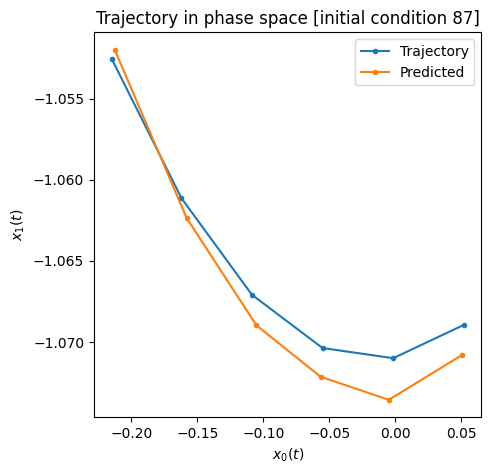

In [361]:
RAN=np.random.randint(0,len(XT[0].cpu().detach().numpy()))
X_traj=XT[:T+1].permute((1,2,0)).cpu().detach().numpy()[RAN]
Y_traj=YT[:T+1,0].permute((1,2,0)).cpu().detach().numpy()[RAN]

fig,ax=plt.subplots(1,figsize=(5,5))
ax.set_title(f"Trajectory in phase space [initial condition {RAN}]")
ax.set_xlabel(r"$x_0(t)$")
ax.set_ylabel(r"$x_1(t)$")
ax.plot(X_traj[0],X_traj[1],label="Trajectory",marker='.')
ax.plot(Y_traj[0],Y_traj[1],label="Predicted",marker='.')
ax.legend()
fig.savefig("random_trajectory.png")
    
